In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
class Option:
    
    def __init__(self, S, K, T, v, r, d):
        self.S = S # Stock Price
        self.K = K # Strike Price
        self.T = T # Time to Maturity (in years)
        self.v = v # Volatility (annualized)
        self.r = r # risk free rate
        self.d = d # dividend rate

    def black_scholes(self, Call=None, Put=None, 
                      delta=None, gamma=None, theta=None, vega=None, rho=None):
        '''
        This works for European Options only
        '''
        d1 = (np.log(self.S / self.K) + ((self.r-self.d)+((self.v**2)/2))*self.T) / (self.v*(self.T**0.5))
        d2 = d1 - self.v*(self.T**0.5)
        
        if gamma == True:
            g = norm.pdf(d1) / (self.S*self.v*(self.T**0.5))
            return(g)
        if vega == True:
            return(self.S*(self.T**0.5)*norm.pdf(d1)*np.exp(-self.d*self.T))

        if Call == True:
            if delta == True:
                return(norm.cdf(d1))
            if theta == True:
                theta_wrt_T = ((-self.S*np.exp(-self.d*self.T)*self.v*norm.pdf(d1))/(2*(self.T**.5))) - (self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(d2))
                return( theta_wrt_T / 252 ) # T is in years, we return theta wrt days
            if rho == True:
                return(self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(d2))

            p = (norm.cdf(d1)*self.S*np.exp(-self.d*self.T) - norm.cdf(d2)*self.K*np.exp(-self.r*self.T))
            return(p)
            
        if Put == True:
            if delta == True:
                return(-norm.cdf(-d1))
            if theta == True:
                theta_wrt_T = ((-self.S*np.exp(-self.d*self.T)*self.v*norm.pdf(d1))/(2*(self.T**.5))) + (self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(-d2))
                return( theta_wrt_T / 252 ) # T is in years, we return theta wrt days
            if rho == True:
                return(-self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(-d2))

            p = (norm.cdf(-d2)*self.K*np.exp(-self.r*self.T) - norm.cdf(-d1)*self.S*np.exp(-self.d*self.T))
            return(p)
        
    def monte_carlo(self, n_sims, Call=None, Put=None, European=None, American=None):
        '''
        This works for European Options and can make it work for American Options
        '''
        payoffs = []
        
        for i in range(n_sims):
            WW = (self.T**0.5) * np.random.normal(0,1,1)
            
            for W in [WW, -WW]: # Antithetic Variates (Variance Reduction Technique)
                S = self.S * np.exp((self.v*W) + (self.r-self.d-((self.v**2)/2))*self.T)

                if Call == True:
                    recieve = S
                    pay = self.K
                if Put == True:
                    recieve = self.K
                    pay = S

                payoffs.append(max(recieve-pay,0))
                
        p = float(np.exp(-self.r*self.T) * np.mean(payoffs))
        return(p)

    def binomial(self, n_steps, Call=None, Put=None, American=None):
        interest = np.exp((self.r-self.d) * (self.T/n_steps)) # i-rate at each step
        discount = np.exp(-self.r * (self.T/n_steps)) # discount-rate at each step --> this is 1/(r*dt)

        u = np.exp(self.v * np.sqrt(self.T/n_steps)) # up movement
        uu = u**2
        d = 1.0/u

        p_up = (interest-d)/(u-d)
        p_down = 1-p_up

        # fill in the endnodes of the tree (when the option expires)
        prices = [] # underlying stock price at option maturity
        prices.append(self.S*(d**n_steps)) # wrost case scenario for underlying stock at option maturity
        for i in range(n_steps):
            prices.append(uu*prices[i]) # all other endnodes

        option_values = [] # option payoffs at maturity
        for i in range(n_steps+1):
            if Call == True:
                option_values.append(max(0, prices[i]-self.K))
            if Put == True:
                option_values.append(max(0, self.K-prices[i]))

        # loop through the tree to find option price today (at time 0)
        for step in range(n_steps-1,-1,-1): # time index going back in time through the tree horizontally
            for i in range(step+1): # price index going through all of the nodes of the tree vertically at each point in time
                option_values[i] = (p_up*option_values[i+1]+p_down*option_values[i])*discount;

                if American == True:
                    prices[i] *= u ## CAN ALSO DO "prices[i] = d*prices[i+1];" here !
                    if Call == True:
                        option_values[i] = max(option_values[i],prices[i]-self.K) # check for exercise
                    if Put == True:
                        option_values[i] = max(option_values[i],self.K-prices[i]) # check for exercise
        return(option_values[0])

    def greeks(self, n_steps=None, n_sims=None, Call=None, Put=None, American=None,
               delta=None, gamma=None, theta=None, vega=None, rho=None):
        '''
        n_sims == None & n_steps == None --> estimate greek using Black Scholes option price
        n_sims == a number --> estimate greek using Monte Carlo simulation of the option price (with n_sims)
        n_steps == a number --> estimate greek using Binomial model option price (with n_steps)

        '''
        
        epsilon = 0.01 # compute option sensitivity to a 0.1% change in the option's parameters
        
        if delta == True:
            self.S *= (1+epsilon) # increase stock price by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.S *= (1-epsilon)/(1+epsilon) # decrease stock price by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.S /= (1-epsilon) # bring stock price back to what it was previously
            
            d = (forward - backward) / (2*epsilon*self.S)
            return(d)

        if gamma == True:
            self.S *= (1+epsilon) # increase stock price by epsilon %
            forward = self.greeks(n_sims=n_sims, n_steps=n_steps, Call=Call, Put=Put, delta=True, American=American)

            self.S *= (1-epsilon)/(1+epsilon) # decrease stock price by epsilon %
            backward = self.greeks(n_sims=n_sims, n_steps=n_steps, Call=Call, Put=Put, delta=True, American=American)

            self.S /= (1-epsilon) # bring stock price back to what it was previously
            
            g = (forward - backward) / (2*epsilon*self.S)
            return(g)

        if theta == True:            
            self.T *= (1-epsilon) # decrease T (pull time forward) by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.T *= (1+epsilon)/(1-epsilon) # increase T (pull time backward) by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.T /= (1+epsilon) # bring T back to what it was previously
            theta_wrt_T = (forward - backward) / (2*epsilon*self.T)
            return( theta_wrt_T / 252 ) # T is in years, we return theta wrt days

        if vega == True:            
            self.v *= (1+epsilon) # increase vol by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.v *= (1-epsilon)/(1+epsilon) # decrease vol by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.v /= (1-epsilon) # bring vol back to what it was previously
            
            v = (forward - backward) / (2*epsilon*self.v)
            return(v)
        
        if rho == True:            
            self.r *= (1+epsilon) # increase r by epsilon %
            forward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                forward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                forward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.r *= (1-epsilon)/(1+epsilon) # decrease r by epsilon %
            backward = self.black_scholes(Call=Call, Put=Put)
            if n_sims != None:
                backward = self.monte_carlo(n_sims=n_sims, Call=Call, Put=Put)
            if n_steps != None:
                backward = self.binomial(n_steps=n_steps, Call=Call, Put=Put, American=American)

            self.r /= (1-epsilon) # bring r back to what it was previously
            
            rho = (forward - backward) / (2*epsilon*self.r)
            return(rho)



In [3]:
# Provide option specs:
option1 = Option(S=90, K=100, T=1, v=0.25, r=0.04, d=0.01)


# Option Price


In [4]:
print(option1.black_scholes(Call=True))
print(option1.monte_carlo(Call=True, n_sims=10000))

print(option1.binomial(Call=True, n_steps=1000)) #European Option by default
print(option1.binomial(Call=True, n_steps=1000, American=True)) #American Option

6.136398139308966
6.219471251563076
6.137879474392158
6.137879474398411


In [5]:
print(option1.black_scholes(Put=True))
print(option1.monte_carlo(Put=True, n_sims=10000))

print(option1.binomial(Put=True, n_steps=1000)) #European Option by default
print(option1.binomial(Put=True, n_steps=1000, American=True)) #American Option

13.11085701711616
13.135470026745732
13.112338352201421
13.72886297417097


# Option Delta

In [6]:
print(option1.black_scholes(Call=True, delta=True))

print(option1.greeks(Call=True, delta=True))
print(option1.greeks(n_sims=200000, Call=True, delta=True))
print(option1.greeks(n_steps=2000, Call=True, delta=True))

print(option1.greeks(n_steps=2000, Call=True, delta=True, American=True))

0.42997333089093615
0.42568740479838885
0.3968524653545339
0.42587007371146884
0.4258700737134593


In [7]:
print(option1.black_scholes(Put=True, delta=True))

print(option1.greeks(Put=True, delta=True))
print(option1.greeks(n_sims=200000, Put=True, delta=True))
print(option1.greeks(n_steps=2000, Put=True, delta=True))

print(option1.greeks(n_steps=2000, Put=True, delta=True, American=True))

-0.5700266691090629
-0.5643624289507755
-0.5500974394646644
-0.5641797600374572
-0.6061718838759995


# Option Gamma

In [8]:
print(option1.black_scholes(Call=True, gamma=True))

print(option1.greeks(Call=True, gamma=True))
print(option1.greeks(n_sims=200000, Call=True, gamma=True))
print(option1.greeks(n_steps=2000, Call=True, gamma=True))

print(option1.greeks(n_steps=2000, Call=True, gamma=True, American=True))

0.017456909599013845
0.017274048128347663
-0.010060688760914096
0.017035093628836685
0.017035093629390964


In [9]:
print(option1.black_scholes(Put=True, gamma=True))

print(option1.greeks(Put=True, gamma=True))
print(option1.greeks(n_sims=200000, Put=True, gamma=True))
print(option1.greeks(n_steps=2000, Put=True, gamma=True))

print(option1.greeks(n_steps=2000, Put=True, gamma=True, American=True))

0.01745690959901384
0.017274048128346237
0.014403431832466541
0.01703509362902931
0.019866140356057837


# Option Theta

In [10]:
print(option1.black_scholes(Call=True, theta=True))

print(option1.greeks(Call=True, theta=True))
print(option1.greeks(n_sims=400000, Call=True, theta=True))
print(option1.greeks(n_steps=2000, Call=True, theta=True))


print(option1.greeks(n_steps=2000, Call=True, theta=True, American=True))

-0.02246769368173133
-0.020947486083433907
-0.02501811435688809
-0.020924438978034112
-0.0209244389785998


In [11]:
print(option1.black_scholes(Put=True, theta=True))

print(option1.greeks(Put=True, theta=True))
print(option1.greeks(n_sims=400000, Put=True, theta=True))
print(option1.greeks(n_steps=2000, Put=True, theta=True))

print(option1.greeks(n_steps=2000, Put=True, theta=True, American=True))

-0.007217067663440486
-0.009232751927742228
-0.008374749948271618
-0.009209704819054412
-0.011437233781286426


# Option Vega

In [12]:
print(option1.black_scholes(Call=True, vega=True))

print(option1.greeks(Call=True, vega=True))
print(option1.greeks(n_sims=400000, Call=True, vega=True))
print(option1.greeks(n_steps=2000, Call=True, vega=True))

print(option1.greeks(n_steps=2000, Call=True, vega=True, American=True))

34.9985011537129
34.998336316624545
36.36650161656814
34.95249340029183
34.952493401358886


In [13]:
print(option1.black_scholes(Put=True, vega=True))

print(option1.greeks(Put=True, vega=True))
print(option1.greeks(n_sims=400000, Put=True, vega=True))
print(option1.greeks(n_steps=2000, Put=True, vega=True))

print(option1.greeks(n_steps=2000, Put=True, vega=True, American=True))

34.9985011537129
34.998336316623124
35.13085542413634
34.952493401071294
33.33975822070947


## Consider the following information on the stock of a company and options on it: 𝑆0 = 49, K = 50, 𝑟 = 0.03, 𝜎 = 0.2, 𝑇 = 0.3846 (20 weeks), 𝜇 = 0.14. Find:
#### 1- Delta of the call option as a function of 𝑆0, for 𝑆0 ranging from 20 to 80, in increments of 2.
#### 2- Delta of the call option, as a function of T (time to expiration), from 0 to 0.3846 in increments of 0.01
#### 3- Theta of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.
#### 4- Gamma of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.
#### 5- Vega of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.
#### 6- Rho of the call option, as a function of 𝑆0, for 𝑆0 ranging from 20 to 80 in increments of 2.

In [14]:
def plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(20,13))

    ax1.plot(x,deltas)
    ax1.set_title('Delta ~ S', size=17)
    ax1.set_xlabel('S$_t$', size=15)
    ax1.tick_params(axis='both', labelsize=12)

    ax2.plot(x2,deltas_wrt_time)
    ax2.set_title('Delta ~ t', size=17)
    ax2.set_xlabel('Time to Maturity (yr)', size=13)
    ax2.tick_params(axis='both', labelsize=12)

    ax3.plot(x,thetas)
    ax3.set_title('Theta', size=17)
    ax3.set_xlabel('S$_t$', size=15)
    ax3.tick_params(axis='both', labelsize=12)

    ax4.plot(x,gammas)
    ax4.set_title('Gamma', size=17)
    ax4.set_xlabel('S$_t$', size=15)
    ax4.tick_params(axis='both', labelsize=12)

    ax5.plot(x,vegas)
    ax5.set_title('Vega', size=17)
    ax5.set_xlabel('S$_t$', size=15)
    ax5.tick_params(axis='both', labelsize=12)

    ax6.plot(x,rhos)
    ax6.set_title('Rho', size=17)
    ax6.set_xlabel('S$_t$', size=15)
    ax6.tick_params(axis='both', labelsize=12)

    plt.show()

## First, estimate the greeks by the BS closed form solutions

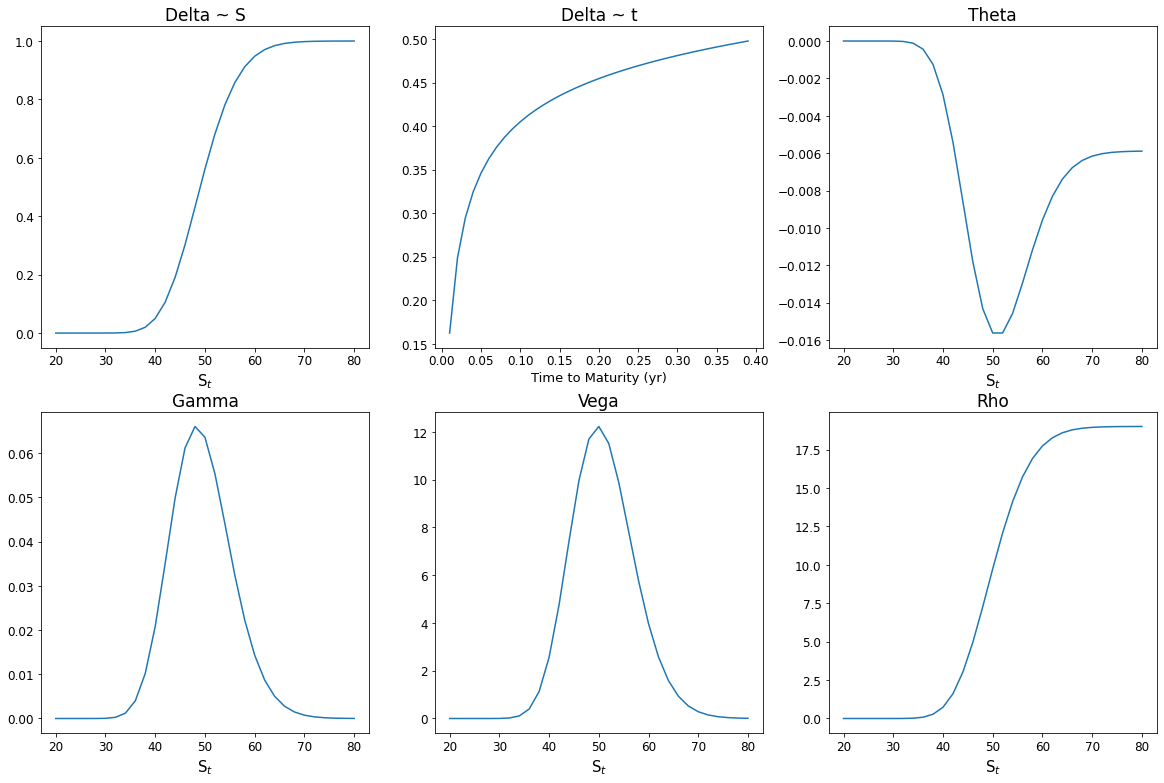

In [15]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.black_scholes(Call=True, delta=True))
    gammas.append(option2.black_scholes(Call=True, gamma=True))
    thetas.append(option2.black_scholes(Call=True, theta=True))
    vegas.append(option2.black_scholes(Call=True, vega=True))
    rhos.append(option2.black_scholes(Call=True, rho=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.black_scholes(Call=True, delta=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Next, estimate the greeks by using the BS model sensitivity

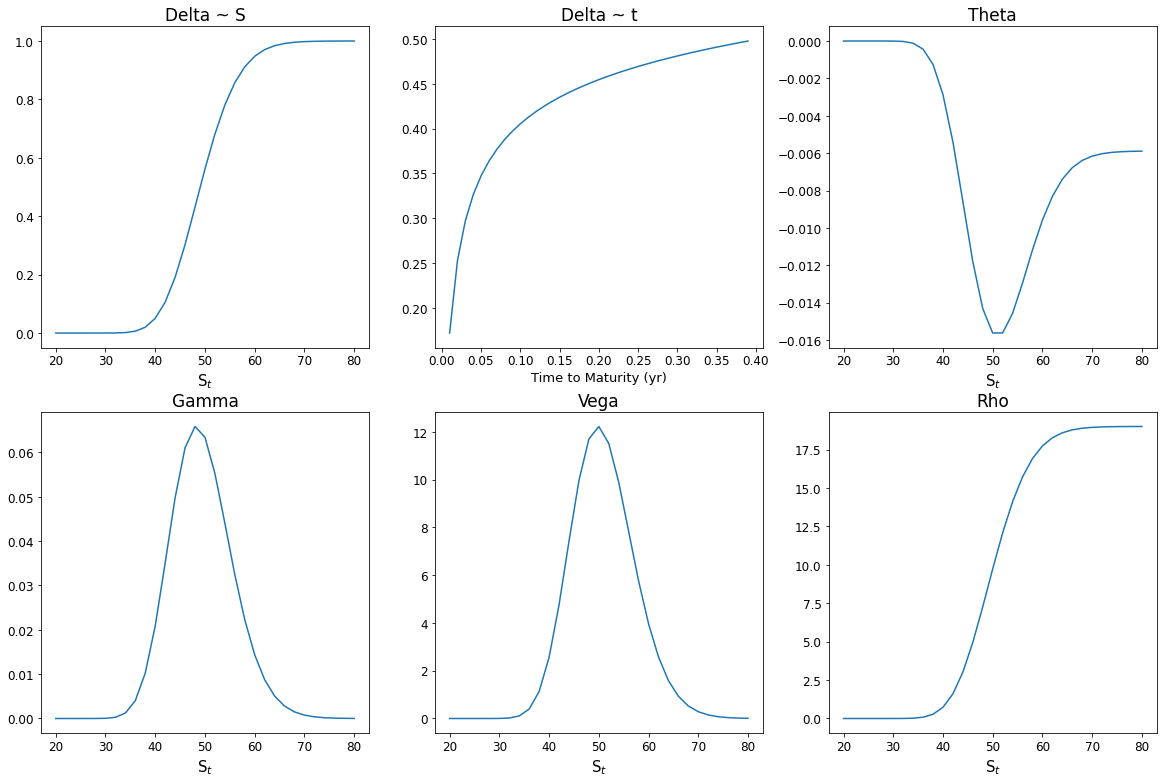

In [16]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True))
    gammas.append(option2.greeks(Call=True, gamma=True))
    thetas.append(option2.greeks(Call=True, theta=True))
    vegas.append(option2.greeks(Call=True, vega=True))
    rhos.append(option2.greeks(Call=True, rho=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Next, estimate the greeks by using the binomial method with n_steps = 500

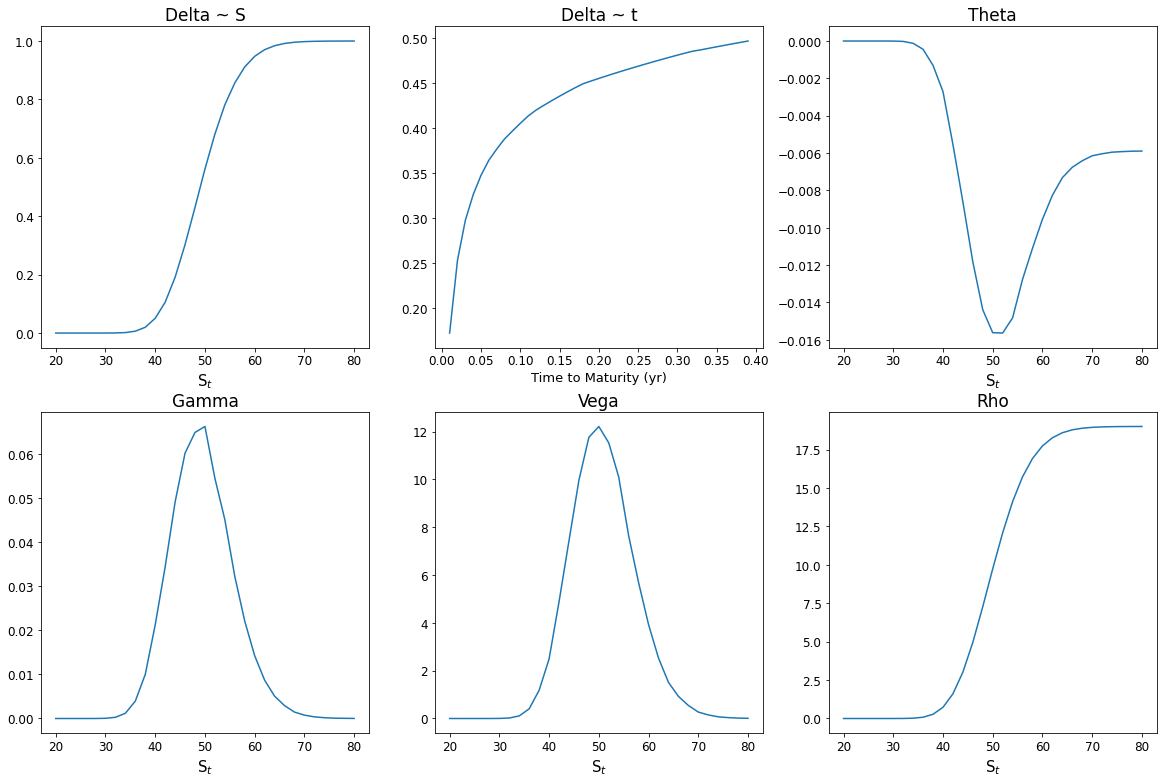

In [17]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True, n_steps=500))
    gammas.append(option2.greeks(Call=True, gamma=True, n_steps=500))
    thetas.append(option2.greeks(Call=True, theta=True, n_steps=500))
    vegas.append(option2.greeks(Call=True, vega=True, n_steps=500))
    rhos.append(option2.greeks(Call=True, rho=True, n_steps=500))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True, n_steps=500))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Try again but this time use n_sims = 200,000 monte-carlo simulations
##### Will take more time to run compared with estimating the greeks by using the BS model or binomial model sensitivities



20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,

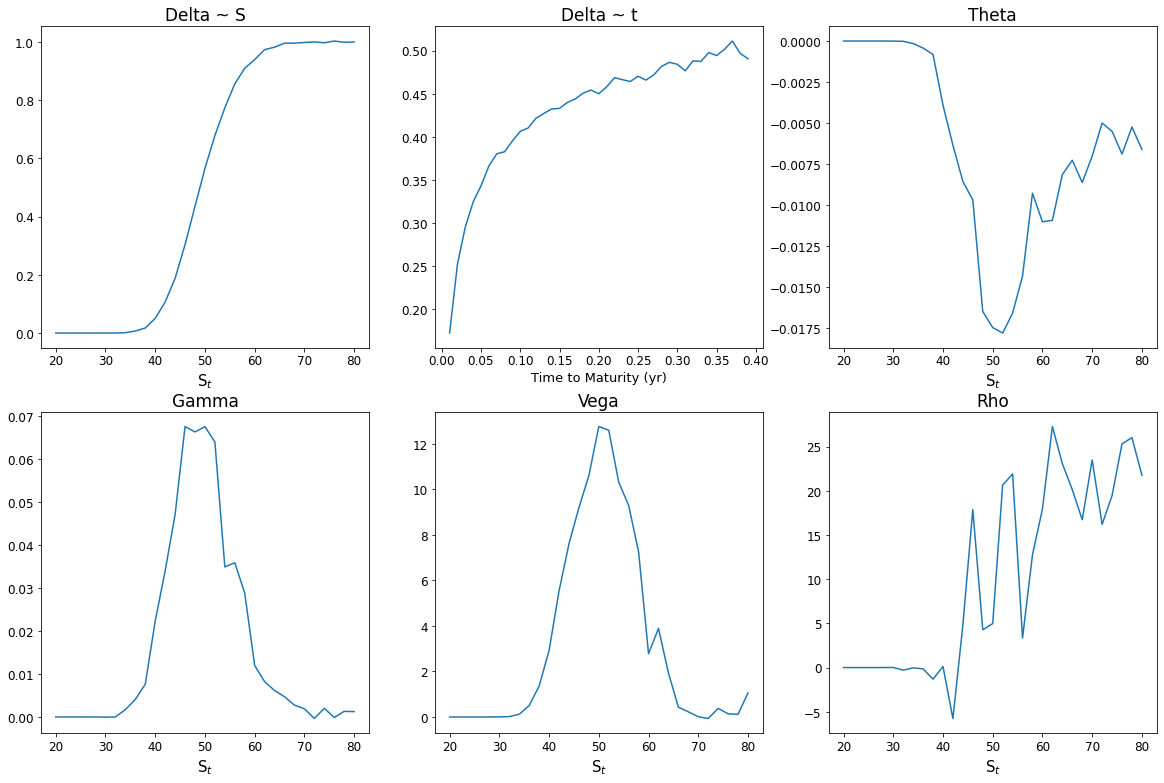

In [18]:
# Try again but this time use n_sims = 100,000 monte-carlo simulations
# this will take a lot more time to run compared with estimating the greeks by using the BS model sensitivity

option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(n_sims=200000, Call=True, delta=True))
    gammas.append(option2.greeks(n_sims=200000, Call=True, gamma=True))
    thetas.append(option2.greeks(n_sims=200000, Call=True, theta=True))
    vegas.append(option2.greeks(n_sims=200000, Call=True, vega=True))
    rhos.append(option2.greeks(n_sims=200000, Call=True, rho=True))
    print(round(option2.S), end=",") # to keep track of loop progress
    
option2.S = 49 # set stock price back to 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(n_sims=200000, Call=True, delta=True))
    print(round(option2.T,2), end=",") # to keep track of loop progress

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Try again but this time use n_steps = 500 binomial tree for American Options

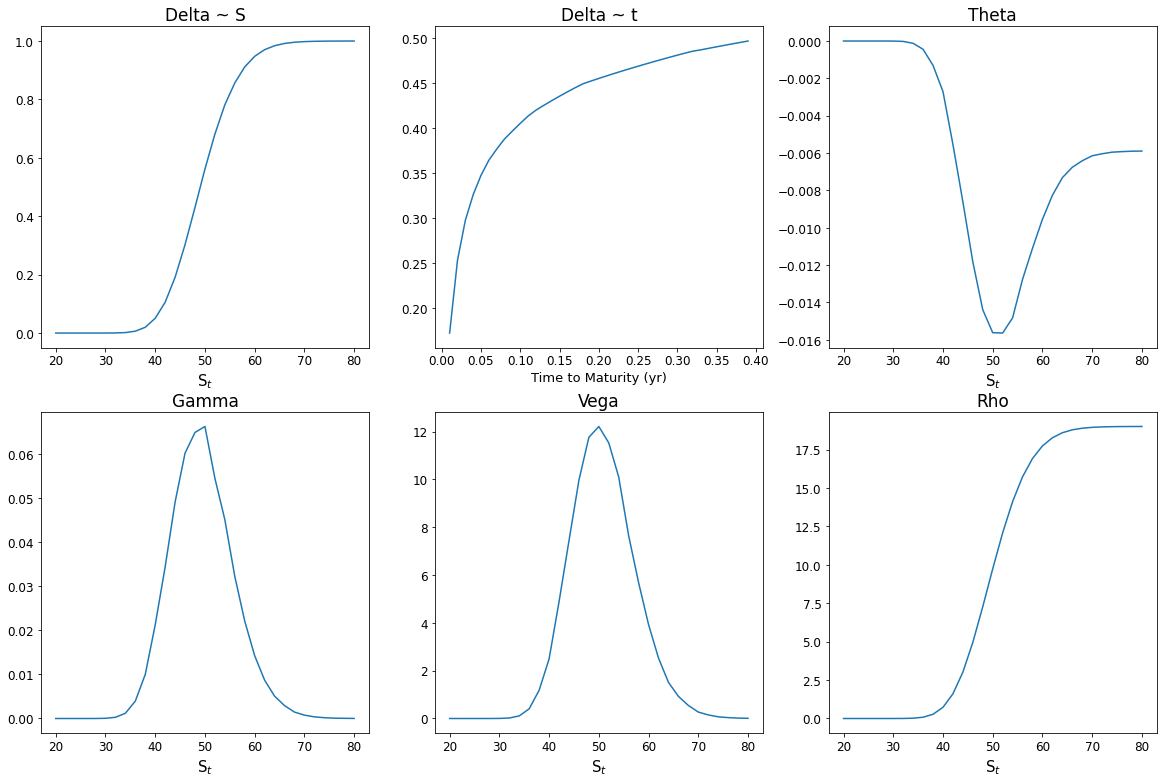

In [19]:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))
    gammas.append(option2.greeks(Call=True, gamma=True, n_steps=500, American=True))
    thetas.append(option2.greeks(Call=True, theta=True, n_steps=500, American=True))
    vegas.append(option2.greeks(Call=True, vega=True, n_steps=500, American=True))
    rhos.append(option2.greeks(Call=True, rho=True, n_steps=500, American=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)

## Try again but this time use the binomial for American Options on dividend paying stock

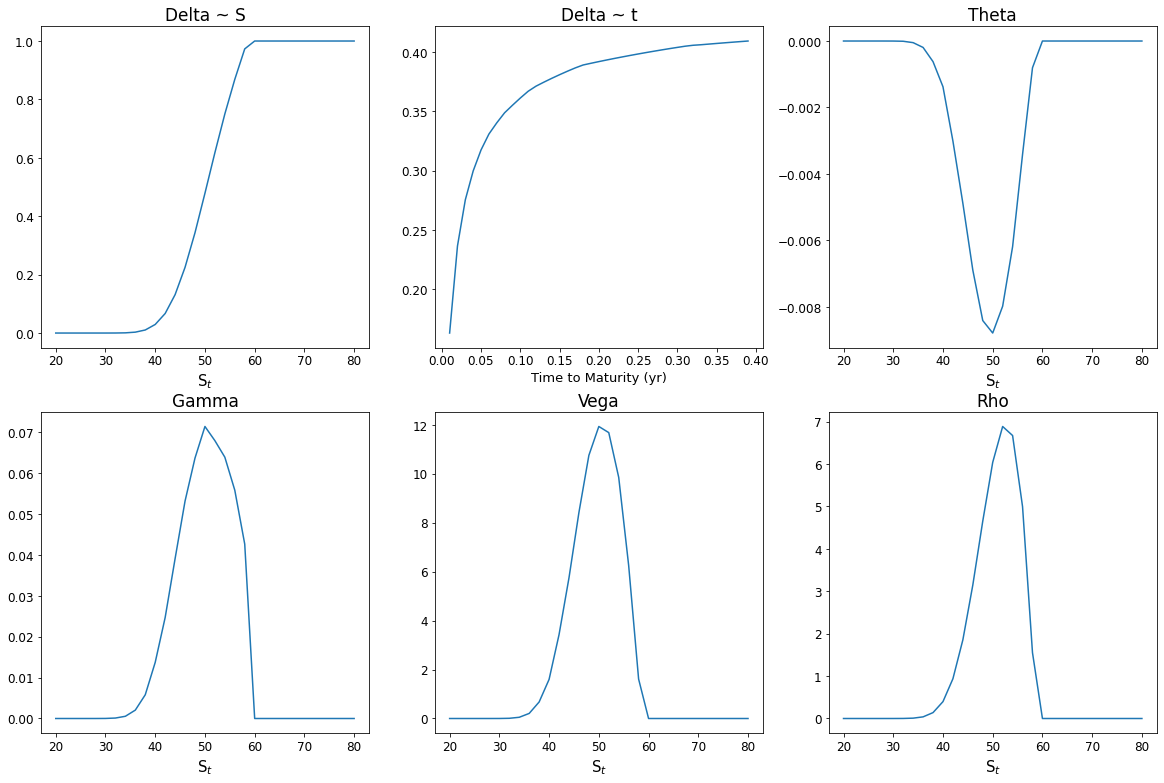

In [20]:
# American option on dividend paying:
option2 = Option(S=49, K=50, T=0.3846, v=0.20, r=0.03, d=0.08) #initialize object

deltas = []
deltas_wrt_time = []
gammas = []
thetas = []
vegas  = []
rhos   = []

x = range(20,82,2) #stock price from 20 to 80 (increments of 2)
x2 = [i/100 for i in range(1,40)] #time from 0.01 to 0.39 in increments to 0.01

for option2.S in x:
    deltas.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))
    gammas.append(option2.greeks(Call=True, gamma=True, n_steps=500, American=True))
    thetas.append(option2.greeks(Call=True, theta=True, n_steps=500, American=True))
    vegas.append(option2.greeks(Call=True, vega=True, n_steps=500, American=True))
    rhos.append(option2.greeks(Call=True, rho=True, n_steps=500, American=True))
    
option2.S = 49
for option2.T in x2:
    deltas_wrt_time.append(option2.greeks(Call=True, delta=True, n_steps=500, American=True))

plot_func(x, x2, deltas, deltas_wrt_time, gammas, thetas, vegas, rhos)